In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 


In [2]:
figformat = '[png]'

In [3]:
dataset_asimov = Dataset_load.create_asimov(cutoff = True)
dataset_load = Dataset_load.create_asimov(cutoff = True)

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


In [4]:
biass = [-0.1, 0.0, 0.1]
bias_assumed = 0.1
sigmass = [0]


In [5]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution = s,
                        rnd = False,
                        e_reco_creation=10,
                        cutoff=True)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(10)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.e_reco_n = 10
    

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((4,4))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/zero**2, 1/zero**2, 1/zero**2])

    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    
    return dataset_conv, dataset_conv_N

datasets_conv =[]
datasets_conv_N =[]

for b in biass:
    dataset_conv, dataset_conv_N  = create_dataset(b, sigmass[0])
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


In [6]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


<WCSAxes: >

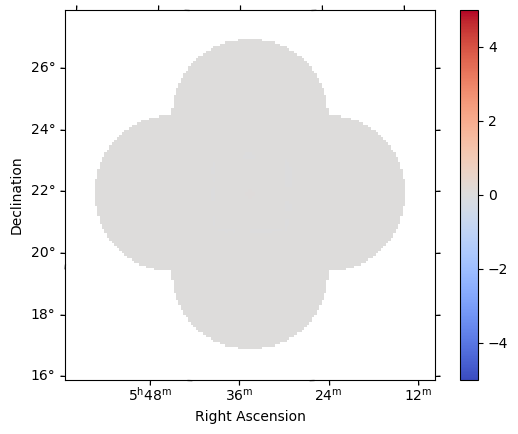

In [7]:
d = dataset_conv_N
d.plot_residuals_spatial()

In [8]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update


/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1123: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update


/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1123: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1123: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


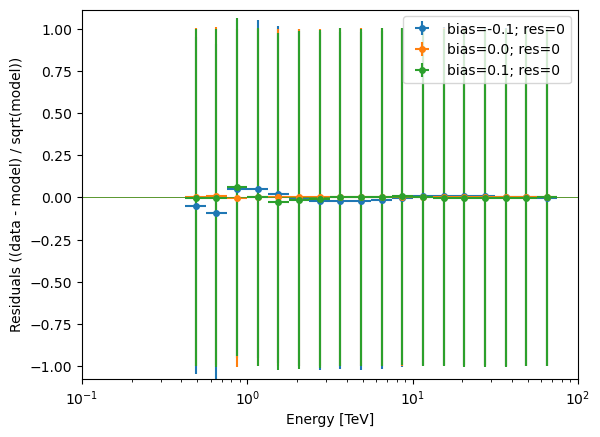

In [45]:
fig, ax = plt.subplots()
i = 0

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}", method = 'diff/sqrt(model)')
        #d = datasets_conv_N_fine[i]
        #d.plot_residuals_spectral(ax =ax, color= colors[1], 
        #            label = f"bias={b}; res={s}")
        i += 1
ax.legend()

fig.savefig(f"plots/2_Residual_pre_fit.png")

In [11]:
npreds_pre_fit = []
npreds_pre_fit_N = []
i =0
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        i += 1

needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf
needs update?
update
_compute_flux_spatial
_compute_flux_spatial_geom
apply_psf


In [12]:
color_standard = 'mediumvioletred'; color_standard_e = 'palevioletred' #mediumvioletred
color_nui = 'midnightblue'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


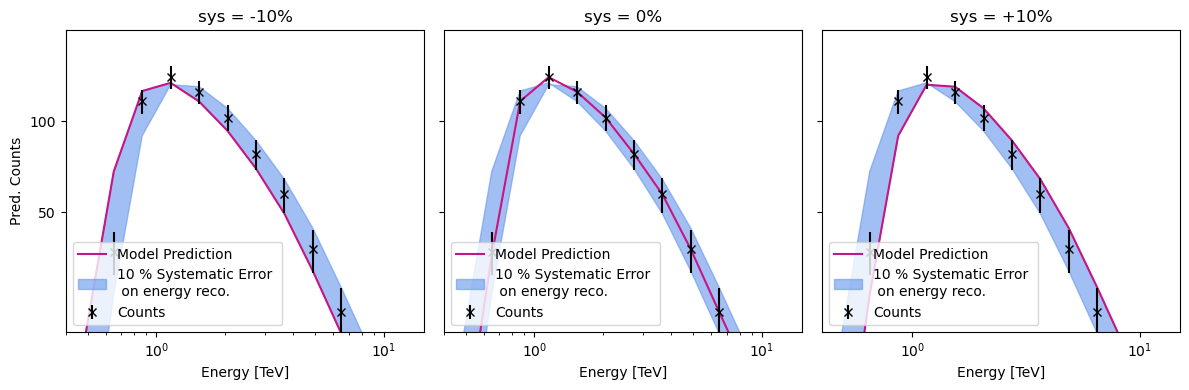

In [15]:

fig,ax = plt.subplots(1,3, sharey = True, figsize =  (12,4))

ax[0].plot(energy,npreds_pre_fit[0], label = "Model Prediction", color = color_standard)
ax[1].plot(energy,npreds_pre_fit[1], label = "Model Prediction", color = color_standard)
ax[2].plot(energy,npreds_pre_fit[2], label = "Model Prediction", color = color_standard)

for a in ax:
    a.fill_between(energy, npreds_pre_fit[0], npreds_pre_fit[2],
                 color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy reco.")
    a.errorbar(energy, sum_e(d.counts.data-d.background.data), 
             yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
            fmt = 'x', label = "Counts", color = 'black')

        
    a.loglog()
    a.legend(loc = 'lower left')
    a.set_xlabel("Energy [TeV]")
    a.set_ylim(2e1, 2e2)
    a.set_yticks([50,100], ['50', '100'])
    a.set_xlim(0.4, 15)
ax[0].set_ylabel("Pred. Counts")
ax[0].set_title("sys = -10%"); ax[1].set_title("sys = 0%"); ax[2].set_title("sys = +10%"); 

plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"plots/2_Npred.svg")


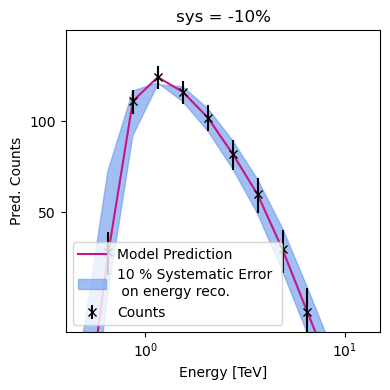

In [44]:

fig,a = plt.subplots(1,1, sharey = True, figsize =  (4,4))

a.plot(energy,npreds_pre_fit[1], label = "Model Prediction", color = color_standard)

a.fill_between(energy, npreds_pre_fit[0], npreds_pre_fit[2],
             color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy reco.")
a.errorbar(energy, sum_e(d.counts.data-d.background.data), 
         yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
        fmt = 'x', label = "Counts", color = 'black')


a.loglog()
a.legend(loc = 'lower left')
a.set_xlabel("Energy [TeV]")
a.set_ylim(2e1, 2e2)
a.set_yticks([50,100], ['50', '100'])
a.set_xlim(0.4, 15)
a.set_ylabel("Pred. Counts")
a.set_title("sys = -10%"); 

plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"plots/2_Npred_single.png")


In [16]:
%%time
fitting = 0

if fitting:

    print("corr")
    for d in datasets_conv:
        fit_cor = Fit(store_trace=True)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(d)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor.minuit)

    for d in datasets_conv_N:
        fit_cor_N = Fit(store_trace=True)
        fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
        result_cor_N = fit_cor_N.run(d)
        d.models.covariance = fit_cor_N.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor_N.minuit)
    
    print("saving")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[i]}_sigma_0.yml'
        d.models.write(path,overwrite=True)
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[i]}_sigma_0.yml'
        d.models.write(path,overwrite=True)
        
else:
    print("read")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[i]}_sigma_0.yml'
        datasets_conv[i] = Dataset_load.load_dataset_N(d, path)        
    print("read nui")
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[i]}_sigma_0.yml'
        datasets_conv_N[i] = Dataset_load.load_dataset_N(d, path)        
        
    



read
read nui
CPU times: user 259 ms, sys: 15.6 ms, total: 275 ms
Wall time: 282 ms


In [17]:
import json
with open("/home/katrin/Documents/nuisance_summary/config.json") as json_data_file:
    config = json.load(json_data_file)

import sys
sys.path.append(config['local']['path']+'/nuisance_summary/Eff_area')
import upper_limit_18_02
import yaml

In [18]:
def get_er_neg_pos(parameter, N, case):
    filename = '5_scan_'+parameter
    if N:
        filename += '_N'
    filename += case
    filename += '.yaml'
    print(filename)
    with open('data/'+filename) as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
        
    ll_N_a = stat_profile_N_a.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)    
    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    return er_neg, er_pos

In [47]:
valuies_asimov_N = []
valuies_asimov = []
cases = ['-10', '', '+10']
par_names = ['amplitude', 'index', 'lambda_']
for i in range(len(datasets_conv)):
    print(i)
    valuies_asimov_Ns = []
    valuies_asimovs = []

    for par in par_names:
        
        try:
            er_neg, er_pos = get_er_neg_pos(par, True, cases[i])
            valuies_asimov_Ns.append([datasets_conv_N[i].models.parameters[par].error, er_neg, er_pos])
        
            er_neg, er_pos = get_er_neg_pos(par, False, cases[i])
            valuies_asimovs.append([datasets_conv[i].models.parameters[par].error, er_neg, er_pos])
        except:
            valuies_asimov_Ns.append(3*[datasets_conv_N[i].models.parameters[par].error])
            valuies_asimovs.append(3*[datasets_conv[i].models.parameters[par].error])
            print('not found ', par, 'dataset:', i)
            
    valuies_asimov_N.append(valuies_asimov_Ns)
    valuies_asimov.append(valuies_asimovs)

print(valuies_asimov_N)
print(valuies_asimov)



0
5_scan_amplitude_N-10.yaml
5_scan_amplitude-10.yaml
5_scan_index_N-10.yaml
5_scan_index-10.yaml
5_scan_lambda__N-10.yaml
5_scan_lambda_-10.yaml
1
5_scan_amplitude_N.yaml
5_scan_amplitude.yaml
5_scan_index_N.yaml
5_scan_index.yaml
5_scan_lambda__N.yaml
5_scan_lambda_.yaml
2
5_scan_amplitude_N+10.yaml
5_scan_amplitude+10.yaml
5_scan_index_N+10.yaml
5_scan_index+10.yaml
5_scan_lambda__N+10.yaml
5_scan_lambda_+10.yaml
[[[1.3433732976953912e-13, 1.4645643914140253e-13, 2.2167816741185065e-13], [0.1766258080133578, 0.5245446932974331, 0.33855776516263525], [0.0582587794664426, 0.07941534706992456, 0.20985253236626164]], [[1.4128244443962173e-13, 1.4645643914140253e-13, 2.2167816741185065e-13], [0.18882553530508142, 0.5245446932974331, 0.33855776516263525], [0.14024909189507234, 0.07513344208664591, 0.14024909189507234]], [[1.4077805396149177e-13, 1.2371933031146365e-13, 1.6100460793957603e-13], [0.22240599217102805, 0.4256641176871603, 0.3822600842199546], [0.05042585916389736, 0.077929741

In [48]:
energy_fine = np.logspace(np.log10(energy_bounds[0].value),
                         np.log10(energy_bounds[-1].value),
                         100)

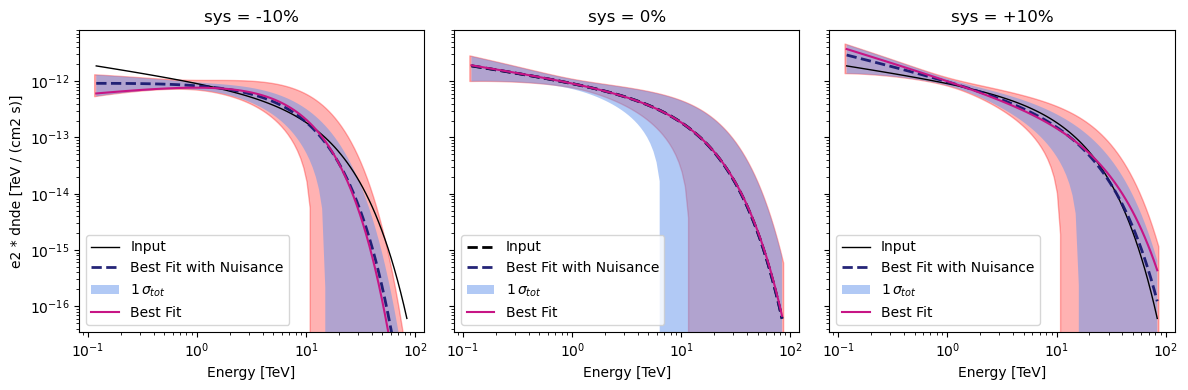

In [49]:


fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )
        
for i in range(len(datasets_conv_N)):
    
    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
  
    m = 1
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
    neg = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
    neg = (neg[0] - neg[1]).value
    m = 2
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m]  
    pos = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
    pos = (pos[0] + pos[1]).value
    
    axs[i].fill_between(energy_fine, neg, pos, alpha = 0.3, color = 'red')
    
    m = 0
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_nui_e,
                                                             label="1$\,\sigma_{tot}$",
                                                            alpha = 0.5)
    
    
    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    #dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
    #                                                       facecolor=color_standard_e,
    #                                                          alpha = 0.9,
    #                                                          label= "1$\,\sigma_{stat}$"
    #                                                         )
[a.legend(loc = 'lower left') for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.svg")

In [50]:
color_nui_e

'cornflowerblue'

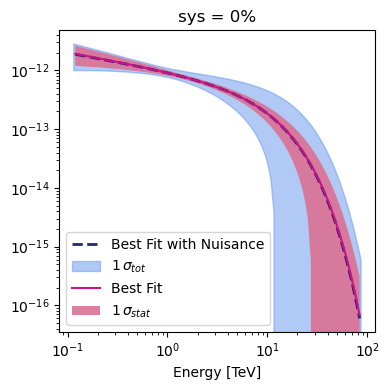

In [51]:


fig,axs = plt.subplots(1,1, sharey=True,figsize = (4,4))
axs = [None, axs, None]

        
for i in range(len(datasets_conv_N)):
    if i == 1:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dotted")
        
        dataset_neg_N = datasets_conv_N[i]
        dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                               color=color_nui,
                                                                 label="Best Fit with Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)        

        m = 1
        for v, p in enumerate(par_names):
            datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
        neg = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
        neg = (neg[0] - neg[1]).value
        m = 2
        for v, p in enumerate(par_names):
            datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m]  
        pos = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
        pos = (pos[0] + pos[1]).value

        axs[i].fill_between(energy_fine, neg, pos, alpha = 0.5, color = color_nui_e,
                           label="1$\,\sigma_{tot}$",)

        m = 0
        #for v, p in enumerate(par_names):
        #    datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
        #dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
        #                                                       facecolor=color_nui_e,
        #                                                         label="1$\,\sigma_{tot}$",
        #                                                        alpha = 0.5)


        dataset_st_neg = datasets_conv[i]
        dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                        label = "Best Fit", color = color_standard)
        dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                               facecolor=color_standard_e,
                                                                  alpha = 0.9,
                                                                  label= "1$\,\sigma_{stat}$"
                                                                 )
axs[1].legend(loc='lower left')
axs[1].set_title("sys = 0%"); 

axs[1].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison_single.png")

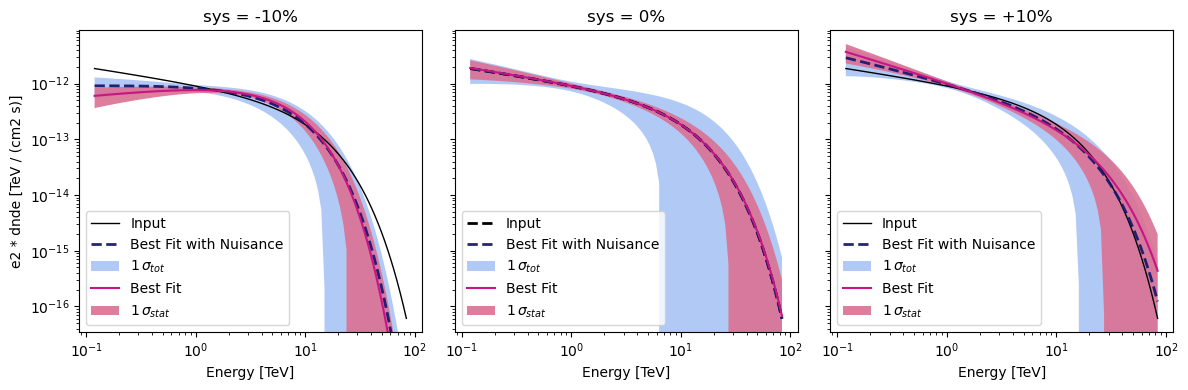

In [52]:
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )
        
for i in range(len(datasets_conv_N)):
    
    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_nui_e,
                                                             label="1$\,\sigma_{tot}$",
                                                            alpha = 0.5)
    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_standard_e,
                                                              alpha = 0.9,
                                                              label= "1$\,\sigma_{stat}$"
                                                             )
[a.legend(loc = 'lower left') for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.svg")

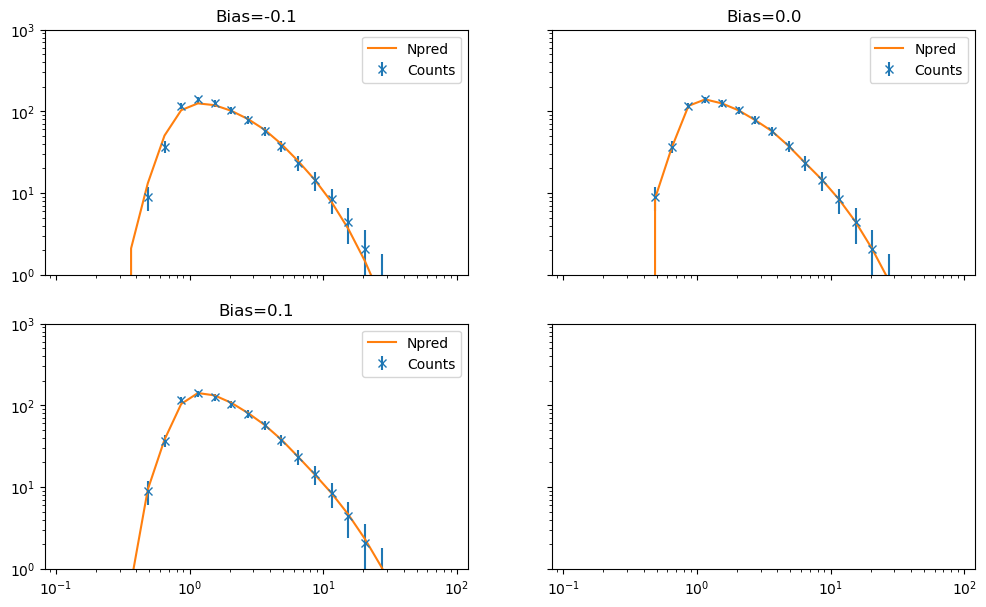

In [32]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_title(f"Bias={b}")
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


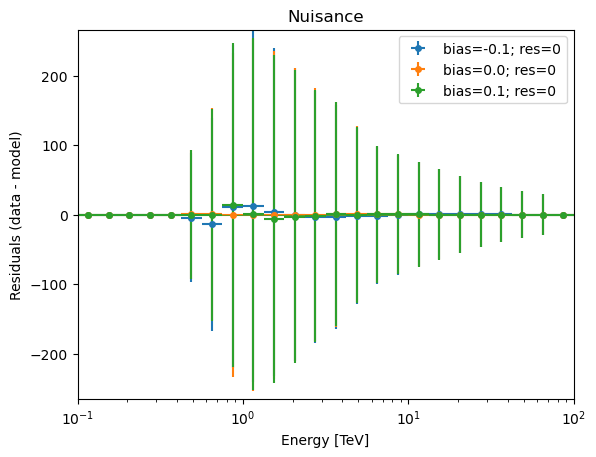

In [33]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Nuisance")

fig.savefig(f"plots/2_Residual_post_fit.svg")

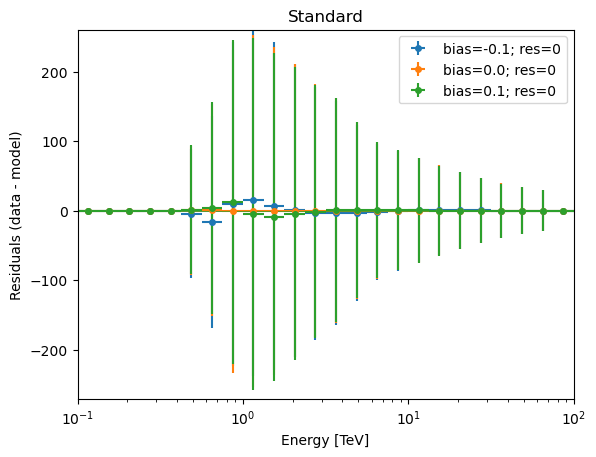

In [34]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Standard")
fig.savefig(f"plots/2_Residual_post_fit_standard.svg")

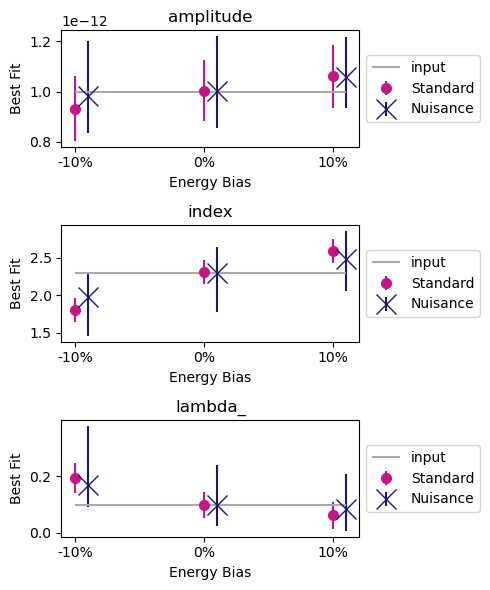

In [37]:
fig, axs = plt.subplots(3,1, figsize= (5, 6))
ax = axs.flatten()


parnames = ['amplitude', 'index', 'lambda_']
ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_standard,markersize = 7,
                          label = f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.1), value, yerr = [[valuies_asimov_N[ii][i][1]],[
                                                    valuies_asimov_N[ii][i][2]]],
                           fmt = 'x', color = color_nui,markersize=14,
                          label ="Nuisance")
            #ax[i].errorbar((ii+0.3), value, yerr = error, fmt = '.', color = color_nui,markersize=14,
            #              label ="Nuisance")
            
        ii +=1
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1+0.1, label = "input", color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
fig.savefig(f"plots/2_Best_fit_parameters.svg")
    

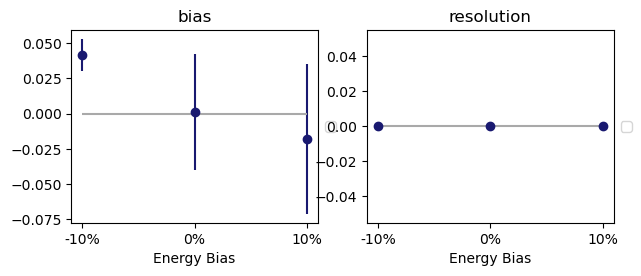

In [36]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_nui)
            ax[i].set_title(p)
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = 0
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1,  color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
fig.savefig(f"plots/2_Best_fit_nui_parameters.svg")
    